# 点度中心性因子重计算

## 导入模块

In [135]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import feather
from tqdm.notebook import tqdm

## 读入日线数据

In [133]:
price_1d = feather.read_dataframe('../data/StockPriceK1d_20240630.feather')
price_1d = price_1d[(price_1d['date'] >= '2019-01-01') & (price_1d['date'] <= '2024-12-31')]
prc = price_1d.sort_values(['date', 'issue']).set_index('date')

In [38]:
trade_date = price_1d['date'].sort_values().unique()
mes = pd.date_range(start=trade_date[0], end=trade_date[-1]+pd.DateOffset(months=1), freq='1ME')
adj_date = np.array([], dtype=np.datetime64)
calc_start_date = np.array([], dtype=np.datetime64)

for me in mes:
    trade_date_before = trade_date[trade_date <= me]
    ad = trade_date_before[-1]
    adj_date = np.append(adj_date, ad)
    if (len(trade_date_before) > 120):
        csd = trade_date_before[-120]
    else:
        csd = trade_date_before[0]
    calc_start_date = np.append(calc_start_date, csd)

adj_date[-1] = pd.Timestamp('2024-06-28')

## 读入测试数据

In [119]:
corr_num = feather.read_dataframe('../data/corr/corr_num_20190830.feather')

## 填充相关性矩阵

In [137]:
issues = pd.DataFrame(columns=['date', 'issue'])
tqdm_date = tqdm(zip(adj_date, calc_start_date), total=len(adj_date))
for ad, csd in tqdm_date:
    idx_date = (price_1d['date'] >= csd) & (price_1d['date'] <= ad)
    issues_date = price_1d.loc[idx_date, 'issue'].sort_values().unique()
    issues_date = pd.DataFrame({'date': ad, 'issue': issues_date})
    if issues.empty:
        issues = issues_date
    else:
        issues = pd.concat([issues, issues_date])
issues = issues.set_index('date')

  0%|          | 0/66 [00:00<?, ?it/s]

In [150]:
def corr_fill(corr, issues_date):
    c = corr.drop(columns=['level_1', 'type', 'date']).set_index('issue')
    c = c.reindex(index=issues_date, columns=issues_date, fill_value=0)
    return c

## 方法1: 稀疏化处理后建立双向连接

In [172]:
def connect_1(corr):
    w = corr.values.copy()
    np.fill_diagonal(w, 0)
    thresh = np.median(w[w > 0])
    w[w <= thresh] = 0
    a = (w > 0).astype(int)
    # a = np.maximum(a, a.T)
    a = np.minimum(a, a.T)
    N_connect = a.sum(axis = 1)
    return N_connect

In [177]:
%%time
remove_num = []
remove_size = []
for ad in tqdm(adj_date):
    ad_str = ad.strftime('%Y%m%d')
    issues_date = issues.loc[ad, 'issue'].to_numpy()
    corr_num = feather.read_dataframe(f'../data/corr/corr_num_{ad_str}.feather')
    corr_num = corr_fill(corr_num, issues_date)
    N_connect_num = connect_1(corr_num)
    r_num = (N_connect_num == 0).sum()
    remove_num.append(r_num / len(issues_date))
    corr_size = feather.read_dataframe(f'../data/corr/corr_size_{ad_str}.feather')
    corr_size = corr_fill(corr_size, issues_date)
    N_connect_size = connect_1(corr_size)
    r_size = (N_connect_size == 0).sum()
    remove_size.append(r_size / len(issues_date))

  0%|          | 0/66 [00:00<?, ?it/s]

CPU times: total: 3min 31s
Wall time: 2min 56s


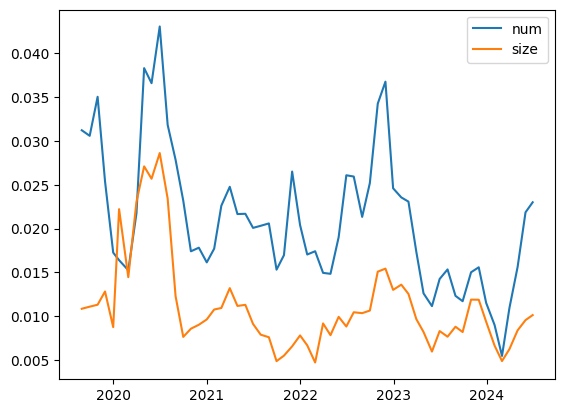

In [179]:
plt.plot(adj_date[7:], remove_num[7:], label='num')
plt.plot(adj_date[7:], remove_size[7:], label='size')
plt.legend()
plt.show()

## 方法2: 先对双向相关度取平均值再稀疏化处理